# Steady Conduction with Mixed Boundary Conditions (Example 2)


In [1]:
import numpy as np
import pyconduct as pyc
from numba import jit
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

In [2]:
c = pyc.PyConduct()

In [3]:
c.lx = 1.
c.ly = 0.5
c.ncvx = 10
c.ncvy = 6
c.set_default()

In [4]:
t0 = 100.
c.phi[:] = t0
c.timeEnd = 2.
c.dt = 1.

In [5]:
c.meshing()

In [6]:
@jit
def gammaUSER(t, xc, yc):
    if xc > 0.7 and yc > 0.25:
        gam = 1 + 0.01 * t
    else:
        gam = 5.
    return gam

@jit
def lambUSER(t, xc, yc):
    lamb = 0.
    return lamb

The following function allows setting the source terms for the boundary conditions, defining the values of $S_c$ and $S_p$. The most commonly used conditions in heat transfer problems are provided as examples:

Dirichlet (known temperature at the boundary):

$$ S_C = T_B \frac{k_B}{\delta x_B} A_B \quad \quad S_P = -\frac{k_B}{\delta x_B} A_B $$

Newman (known heat flux):

$$ S_C = q_B A_B \,  \quad \quad S_P = 0 $$

Robin (convection):

$$ S_C = \left(\frac{h_B \frac{k_B}{\delta x_B}}{h_B + \frac{k_B}{\delta x_B}}\right) T_{\infty} A_B \quad \quad S_P = -\left(\frac{h_B \frac{k_B}{\delta x_B}}{h_B +\frac{k_B}{\delta x_B}}\right) A_B $$

The input variables of the function are:

- b: edge index
    - b == 1: bottom edge,
    - b == 2: right edge,
    - b == 3: top edge, and
    - b == 4: left edge.
- c: cell index
- f: face index
- i: connectivity index
- xf, yf: face center node coordinates
- timer: time
- $\Gamma$, $k_B$: gamma[c], diffusion coefficient
- $\lambda$: lamb
- Node distance from internal node to the edge $\delta x$: ndist[i], dx
- Cell volume $V$: cvol[c]
- Volume-edge interface area $A_B$: af[f], area

In [8]:
@jit
def sourcesBound(b, c, f, i, ndist, cvol, af, gamma, lamb, xf, yf, timer):
    
    gam = gamma[c]
    dx = ndist[i]
    vol = cvol[c]
    area = af[f]
    xff = xf[f]
    yff = yf[f]
    
    qw = 800.
    tinf = 5.
    he = 20.
    tw1 = 100.
    tw2 = 20.
    
   
    if(b == 1):    #- 1: S
        scb = qw * area
        spb = 0.
        
    elif(b == 2):  #- 2: E
        scb = ((he * gam / dx) / (he + gam / dx)) * tinf * area
        spb = -((he * gam / dx) / (he + gam / dx)) * area
        
    elif(b == 3):  #- 3: N
        if xff > 0.7:
            scb = tw2 * gam / dx * area
            spb = - gam / dx * area
        else:
            scb = 0.
            spb = 0.
        
    elif(b == 4):  #- 4: W
        scb = tw1 * gam / dx * area
        spb = - gam / dx * area
        
    else:
        scb = 0.
        spb = 0.
        
    return scb, spb


The sourcesVol function allows the user to define volumetric source terms. These source terms can depend on:

- c: cell index
- vol: cell volume
- xc, yc: cell center coordinates
- phi: calculated scalar
- timer: time

The unsteadySources function allows defining the terms for the discretization of the transient term:

- phi: calculated scalar
- phi1: scalar from the previous time step
- phi2: scalar from the time step before phi1
- lamb: property
- dt: time step
- cvol: cell volume
- c: cell index
- titer: time step counter

In [9]:
@jit
def sourcesVol(c, vol, phi, xc, yc, timer):
    xcc = xc[c]
    ycc = yc[c]
    t = phi[c]
    a = 1000.
    b = 4e-5
    if xcc > 0.7 and ycc > 0.25:
        scv = 0.
        spv = 0.
    else:
        scv = a + 2 * b * t**3
        spv = -3 * b * t**2
    return scv * vol, spv * vol


@jit              
def unsteadySources(phi, phi1, phi2, lamb, dt, cvol, c, titer):
    #vol = cvol[c]
    #Euler
    #ap0 = lamb[c] / dt * vol
    #apts = -ap0 
    #acts = ap0 * phi1[c]
    return 0,0  #apts, acts

The names of the user-created functions mentioned above should be provided to the PyConduct class; otherwise, default internal functions will be executed.

In [10]:
c.gammaFunction = gammaUSER
c.lambFunction = lambUSER
c.unsteadySourcesFunction = unsteadySources
c.sourcesVolFunction = sourcesVol
c.sourcesBoundFunction = sourcesBound

Reports:

- sol: select the solver for the discretized equation system:
    - 1: direct method
    - 2: CG
    - 3: GMRES
    - 4: LGMRES
    - 5: MINRES
    - 6: QMR
- reportBlackW: frequency of displaying a report on the screen after a certain number of time steps, including:
- time: time
- iter_t: number of iterations in the transient process
- nl_iter: number of iterations to solve the nonlinearity of the problem
- errNl: convergence of iterations due to nonlinearity
- reportContour: number of time steps to display a contour report of $\phi$ on the screen

In [11]:
c.sol = 2
c.reportBlackW = 1
c.reportContour = 1

Start the simulation with the run_simulation() method of the class.

*PyConduct uses Numba to accelerate the calculation. Python is an interpreted and slow language for scientific computation. Numba is a just-in-time (JIT) compiler for Python that aims to accelerate numerical computations. When Numba encounters a decorated function, it needs to compile it before executing it. This incurs additional time for compilation during the first execution. However, once the function is compiled, subsequent executions will be much faster since there is no need to recompile it. Therefore, the first execution may be slower, but subsequent executions will benefit from the acceleration provided by Numba.*

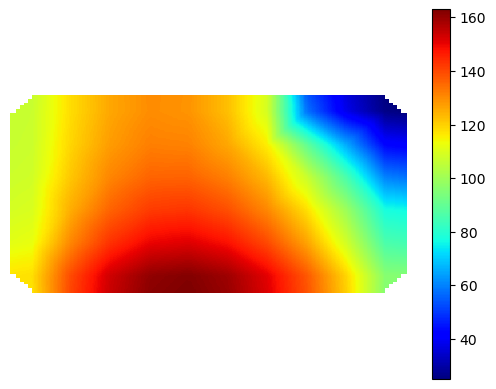

time = 1.0  iter_t = 1  nl_iter = 5  errNl = 0.0


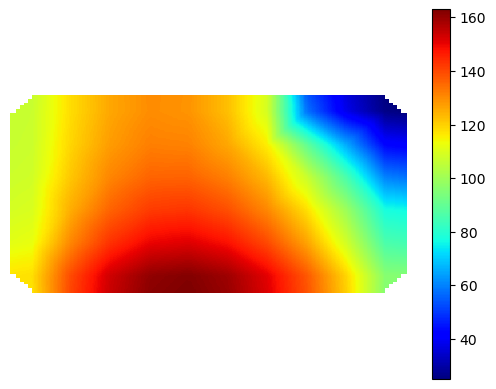

time = 2.0  iter_t = 2  nl_iter = 0  errNl = 0.0
calculation complete


In [12]:
c.run_simulation()

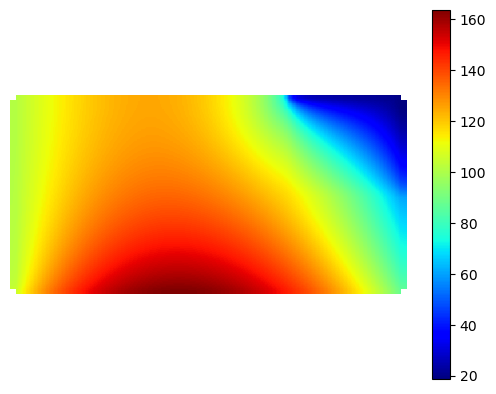

calculation complete


In [13]:
c.lx = 1.
c.ly = 0.5
c.ncvx = 10 * 6
c.ncvy = 6 * 6
c.set_default()
t0 = 100.
c.phi[:] = t0
c.timeEnd = 2.
c.dt = 1.
c.meshing()
c.run_simulation()